# Spatial Impainting Tool (Version 0)


The following notebook defines a bounding box around the greater Washington D.C. area, spanning southwards to Hampton, Virginia where the TEMPO data is hosted at the Atmospheric Science Data Center at NASA Langley. Users can define a separate bounding box of interest.

Within this bounding box, the tool has to iterate through all 190 Pandora stations to detect available Pandora stations from a defined bounding box, because Latitude and Longitude of Pandora stations are contained within their data files.

Once all available Pandora stations are extracted and stored, the user then defines a date range of interest.

- [TEMPO](https://www.earthdata.nasa.gov/data/instruments/tempo)
- [PANDORA](https://pandora.gsfc.nasa.gov/)


## User Requirements
- User must have a NASA earthaccess account
- Notebook assumes execution in local directory
- <font color='red'>[HERE](http://data.asdc.earthdata.nasa.gov/asdc-prod-public/mission-support-documents/PREFIRE/gap_filling_model.pt)</font>
- click the above link to download and save the `gap_filling_model.pt` in the same directory as this jupyter notebook.
- REQUIRES SHAPEFILE DOWNLOAD IN LOCAL DIRECTORY


## Notes on TEMPO NO2 validation
This notebook illustrates comparison of nitrogen dioxide tropospheric column retrievals by TEMPO and Pandora ground stations.

It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibilty to select the station within TEMPO's field of regard (FOR). If the selected station is outside FOR, no TEMPO time series will be generated.

The user is allowed to choose the time period of interest by providing start and end dates in the form YYYYMMDD. Please be aware, that if the selecte period of interest is outside of available time span of one of the sensors, corresponding time series will not be generated.

Data files for both sensors are downloaded on-the-fly. TEMPO data are downloaded with earthaccess library that needs to be installed first.

TEMPO data files are read by means of netCDF library that needs to be installed first.

Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read nitrogen dioxide total column along with its total uncertainty.

This code takes into account quality flags (QFs) from both TEMPO and Pandora. This is implemented as follow. On the TEMPO side, data set "/product/main_data_quality_flag" is read, all pixels with non-zero QFs are discarded. However, negative values of tropospheric NO2 column are NOT discarded and used for averaging/interpolationg to the point of interest. For the purpose of physical sanity, another way is also implemented, i.e., negative retrievals are not used in averaging. Therefore, TWO values are returned, trop_NO2_col, and trop_NO2_col_noneg. On Pandora side negative columns also occur despite high quality flags, though they are rare. So, two Pandora time series are considered - with and without negative columns.

The resulting time series are plotted with and without uncertainty of both measurement in the end of the notebook.

This notebook is tested on TEMPO_NO2_L2_V03 and Pandora L2_rnvh3p1-8 files.

In [1]:
!python -m pip install -qq pyproj opencv-python torch

In [2]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data
import os
import sys
import re
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
import platform
from subprocess import Popen
import shutil
import seaborn as sns
from tqdm import tqdm
from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest
from scipy import stats # needed for linear regression analysis

import requests # needed to search for and download Pandora data
import codecs # needed to   read Pandora data
import numpy as np

import matplotlib.pyplot as plt # needed to plot the resulting time series
from urllib.request import urlopen, Request # needed to search for and download Pandora data
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime, timedelta # needed to work with time in plotting time series
import math

import joblib
import pyproj
# import pyrsig
import pandas as pd
import getpass
import matplotlib.pyplot as plt
import folium
from functools import reduce
from tqdm import tqdm 

from typing import List, Union, Optional
from pathlib import Path
from datetime import date, datetime
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
import time
import os
import pandas as pd
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.gridspec import GridSpec
from scipy.stats import spearmanr

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn import metrics
from PIL import Image
import cv2
pd.set_option('display.max_columns', None)
from scipy.stats import zscore


import os, glob, math, random
from scipy import stats
from sklearn import metrics
from matplotlib.collections import LineCollection
import torch.nn as nn
import torch.nn.functional as F
from rasterio.plot import show as rio_show
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from matplotlib import patheffects as pe
import shapefile
import scipy
import warnings
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import csv

import torch
import geopandas as gpd

from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
from pyproj import Transformer
from scipy.ndimage import gaussian_filter
import torch.nn as nn
from scipy.ndimage import laplace
import rasterio
from io import BytesIO
# Establishing access to EarthData
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

##creating local directory
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Enter your Earthdata Login username:  hazem.mahmoud88
Enter your Earthdata password:  ········


Saved .dodsrc to: /home/jovyan/


In [3]:
# functions to work with pandora
# function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
def take_pandora_sites(refs):
  print('please select a Pandora site name from the list')
  for ref in refs:
    print(ref)

  answer = 'y'
  while answer == 'y':
    site_name = input('Enter a name of a Pandora site: ')
    print(site_name)
    site_list = check_site(site_name, refs)
    site_num = len(site_list)
    if site_num == 0:
      print('site ', site_name, 'was not found')
      continue

    if site_num > 1:
      print('there are ', site_num, ' site names, select one from')
      for site in site_list: print(site)

      site_name = input('Enter a name of a Pandora site: ')
      if site_list.count(site_name) != 1:
        print('Entered name is not the exact match of one of the following sites')
        for site in site_list: print(site)
        print('program terminated')
        sys.exit()

      for site in site_list:
        if site == site_name:
          pandora_site = site_name
          print('site ', site_name, 'was found and added to the list of sites ')
          break

    if site_num == 1:
      pandora_site = site_list[0]
      print('site ', site_list[0], 'was found and added to the list of sites ')

    answer = 'n'

  return pandora_site

def read_timestamp(timestamp):
  yyyy = int(timestamp[0:4])
  mm = int(timestamp[4:6])
  dd = int(timestamp[6:8])
  hh = int(timestamp[9:11])
  mn = int(timestamp[11:13])
  ss = int(timestamp[13:15])
  return yyyy, mm, dd, hh, mn, ss


def read_Pandora_NO2_rnvh3p1_8(fname, start_date, end_date):
  conversion_coeff = 6.02214076E+19 # Avogadro constant divided by 10000
  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., data

  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:
    while True:
      line = f.readline()
      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        print('location name ', loc_name)
      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        print('location latitude ', lat)
      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        print('location longitude ', lon)
      if line.find('--------') >= 0: break
    while True:
      line = f.readline()
      # print(line)
      if line.find('--------') >= 0: break
    while True:
      line = f.readline()
      if not line: break
      line_split = line.split()
      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      QF = int(line_split[52]) # total column uncertainty

      if QF == 0 or QF == 10:
        column = float(line_split[61]) # Nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        column_unc = float(line_split[62]) # Independent uncertainty of nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        
        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss\
                               , column*conversion_coeff\
                               , column_unc*conversion_coeff]], axis = 0)

  return lat, lon, loc_name, data

def generate_pandora_csv(coordinates, all_sites_list, start_date, end_date):
    """
    Master pipeline to generate a Pandora NO2 CSV for a bounding box and date range.
    Includes automatic cleanup of temporary Pandora text files.

    Parameters
    ----------
    coordinates : list of tuples
        List of (lat, lon) tuples defining bounding box in order:
        [(NW_lat, NW_lon), (NE_lat, NE_lon), (SE_lat, SE_lon), (SW_lat, SW_lon)]
    start_date : str
        Start date in 'YYYY-MM-DD' format for filtering final data.
    end_date : str
        End date in 'YYYY-MM-DD' format for filtering final data.

    Returns
    -------
    df_filtered : pandas.DataFrame
        Final filtered Pandora dataset.
    """

    try:
        site_locations, df_sites = get_sites_in_bounding_box_optimized(coordinates,all_sites_list)
        if df_sites.empty:
            print("No Pandora sites found within bounding box — exiting.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error in bounding box extraction: {e}")
        return pd.DataFrame()

    try:
        download_and_extract_info_for_filtered_sites("pandora_sites_in_bounding_box.csv")
    except Exception as e:
        print(f"Error downloading files: {e}")
        return pd.DataFrame()

    try:
        df_all = extract_all_pandora_data_to_csv(
            file_pattern="*Pandora*.txt",
            output_csv="pandora_metadata_complete.csv"
        )
        if df_all.empty:
            print("No data extracted from downloaded files — exiting.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error during extraction: {e}")
        return pd.DataFrame()


    try:
        df_filtered = filter_pandora_data_by_date(
            df_all, start_date=start_date, end_date=end_date
        )
        if df_filtered.empty:
            print("No data found in specified date range.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error during date filtering: {e}")
        return pd.DataFrame()

    try:
        final_csv = "pandora_filtered_final.csv"
        df_filtered.to_csv(final_csv, index=False)
        print(f"Final filtered Pandora CSV saved to: {final_csv}")

        # Optional: create summary per station
        create_station_summary(df_filtered, "pandora_station_summary_filtered.csv")
    except Exception as e:
        print(f"Error saving outputs: {e}")

    try:
        txt_files = glob.glob("*Pandora*.txt")
        if txt_files:
            for f in txt_files:
                try:
                    os.remove(f)
                    print(f"Deleted temporary file: {f}")
                except Exception as fe:
                    print(f"Could not delete {f}: {fe}")
        else:
            print("No temporary Pandora files to clean up.")
    except Exception as e:
        print(f"Cleanup step failed: {e}")


    return df_filtered

def custom_collate_fn(batch):
    out = {}
    keys = batch[0].keys()
    for k in keys:
        v0 = batch[0][k]
        if isinstance(v0, torch.Tensor):
            out[k] = torch.stack([b[k] for b in batch], dim=0)
        else:
            # Keep as list so we can index it later
            out[k] = [b[k] for b in batch]
    return out

class SelfAttention2D(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(SelfAttention2D, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction
        
        # Query, Key, Value projections
        self.query = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Output projection
        self.out_proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Learnable parameter to control attention influence
        self.gamma = nn.Parameter(torch.zeros(1))
        
        # Normalization
        self.norm = nn.LayerNorm([in_channels])
        
    def forward(self, x, mask=None):
        batch_size, C, H, W = x.size()
        
        # Generate Q, K, V
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # [B, HW, C//r]
        key = self.key(x).view(batch_size, -1, H * W)  # [B, C//r, HW]
        value = self.value(x).view(batch_size, -1, H * W)  # [B, C, HW]
        
        # Compute attention scores
        attention = torch.bmm(query, key)  # [B, HW, HW]
        
        # Apply mask to attention if provided
        if mask is not None:
            mask_flat = mask.view(batch_size, 1, H * W)  # [B, 1, HW]
            mask_matrix = torch.bmm(mask_flat.transpose(1, 2), mask_flat)  # [B, HW, HW]
            attention = attention * mask_matrix
            attention = attention.masked_fill(mask_matrix == 0, float('-inf'))
        
        # Softmax normalization
        attention = F.softmax(attention, dim=-1)  # [B, HW, HW]
        
        # Apply attention to values
        out = torch.bmm(value, attention.permute(0, 2, 1))  # [B, C, HW]
        out = out.view(batch_size, C, H, W)  # [B, C, H, W]
        
        # Output projection
        out = self.out_proj(out)
        
        # Residual connection with learnable parameter
        out = self.gamma * out + x
        
        # Layer normalization
        out = out.permute(0, 2, 3, 1)  # [B, H, W, C]
        out = self.norm(out)
        out = out.permute(0, 3, 1, 2)  # [B, C, H, W]
        
        return out

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x


# ---- Simple channel attention ----
class SimpleChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 4, in_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# ---- Extended UNet (enc5/dec4 added) ----
class OriginalPlusMinimalAttentionDeepOld(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32):
        super().__init__()

        # Encoder (5 levels now)
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc4 = PConv2D(base_ch*4, base_ch*8, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc5 = PConv2D(base_ch*8, base_ch*16, stride=2, activation=nn.LeakyReLU(0.1))

        # Bottleneck
        self.bot = PConv2D(base_ch*16, base_ch*16, activation=nn.LeakyReLU(0.1))
        self.dilated = DilatedBlock(base_ch*16, base_ch*16, dilations=(1,2,4,8))
        self.bottleneck_attention = SimpleChannelAttention(base_ch*16)

        # Decoder (symmetric)
        self.up4 = nn.ConvTranspose2d(base_ch*16, base_ch*8, kernel_size=2, stride=2)
        self.dec4 = PConv2D(base_ch*16, base_ch*8, activation=nn.LeakyReLU(0.1))

        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = PConv2D(base_ch*8, base_ch*4, activation=nn.LeakyReLU(0.1))

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))

        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

        # Gated skips (4 gates now)
        self.gate4 = GatedSkip2d(ch_skip=base_ch*8, ch_up=base_ch*8)
        self.gate3 = GatedSkip2d(ch_skip=base_ch*4, ch_up=base_ch*4)
        self.gate2 = GatedSkip2d(ch_skip=base_ch*2, ch_up=base_ch*2)
        self.gate1 = GatedSkip2d(ch_skip=base_ch,   ch_up=base_ch)

    def forward(self, img, mask):
        # Encoder
        e1, m1 = self.enc1(img, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)
        e4, m4 = self.enc4(e3, m3)
        e5, m5 = self.enc5(e4, m4)

        # Bottleneck
        b, mb = self.bot(e5, m5)
        b = self.dilated(b)
        b = self.bottleneck_attention(b)

        # Decoder
        up4 = self.up4(b)
        e4_g = self.gate4(e4, up4)
        d4_in = torch.cat([up4, e4_g], dim=1)
        m4_in = torch.maximum(F.interpolate(mb, scale_factor=2, mode="nearest"), m4)
        d4, md4 = self.dec4(d4_in, m4_in)

        up3 = self.up3(d4)
        e3_g = self.gate3(e3, up3)
        d3_in = torch.cat([up3, e3_g], dim=1)
        m3_in = torch.maximum(F.interpolate(md4, scale_factor=2, mode="nearest"), m3)
        d3, md3 = self.dec3(d3_in, m3_in)

        up2 = self.up2(d3)
        e2_g = self.gate2(e2, up2)
        d2_in = torch.cat([up2, e2_g], dim=1)
        m2_in = torch.maximum(F.interpolate(md3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        up1 = self.up1(d2)
        e1_g = self.gate1(e1, up1)
        d1_in = torch.cat([up1, e1_g], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1
    
class PConv2D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, use_bias=True, activation=None):
        super().__init__()
        self.ks = kernel_size
        self.stride = stride
        self.activation = activation if activation is not None else nn.Identity()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride,
                              padding=kernel_size // 2, bias=use_bias)
        self.register_buffer("mask_kernel", torch.ones(1, 1, kernel_size, kernel_size))

    def forward(self, img, mask):
        # masked convolution on the image
        img = img.float()
        mask = mask.float()

        img_out = self.conv(img * mask)

        # count of valid pixels per window (no clamping!)
        with torch.no_grad():
            mask_count = F.conv2d(mask, self.mask_kernel,
                                  stride=self.stride, padding=self.ks // 2)

        # normalize by (#elements / count) and gate where count>0
        n = float(self.ks * self.ks)
        eps = 1e-8
        mask_ratio = n / (mask_count + eps)
        mask_any   = (mask_count > 0).float()

        img_out = img_out * mask_ratio * mask_any
        return self.activation(img_out), mask_any



class DilatedBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilations=(1, 2, 4)):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=d, dilation=d)
            for d in dilations
        ])
        self.proj = nn.Conv2d(len(dilations) * out_ch, out_ch, kernel_size=1)

    def forward(self, x):
        feats = [conv(x) for conv in self.convs]
        out = torch.cat(feats, dim=1)
        return F.leaky_relu(self.proj(out), 0.1)


class GatedSkip2d(nn.Module):
    """Learn a per-pixel gate for the encoder skip before concatenation.
       gate = σ(Conv1x1([skip, up])) ;  gated_skip = gate * skip
    """
    def __init__(self, ch_skip, ch_up, hidden=None):
        super().__init__()
        if hidden is None:
            hidden = max(ch_skip // 2, 8)
        self.conv = nn.Sequential(
            nn.Conv2d(ch_skip + ch_up, hidden, kernel_size=1, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(hidden, ch_skip, kernel_size=1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, skip, up):
        gate = self.conv(torch.cat([skip, up], dim=1))
        return skip * gate



def _wrap_lon_180(lons):
    """Normalize longitudes to [-180, 180]."""
    arr = np.asarray(lons, dtype=float)
    m = np.isfinite(arr)
    arr[m] = ((arr[m] + 180.0) % 360.0) - 180.0
    return arr
def _lonlat_to_rowcol_vec(lons, lats, transform, raster_crs):

    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # mask invalid inputs
    good = np.isfinite(lons) & np.isfinite(lats)
    rows = np.full_like(lons, fill_value=np.nan, dtype=float)
    cols = np.full_like(lons, fill_value=np.nan, dtype=float)

    if not good.any(): return np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    try:
        from pyproj import CRS, Transformer
        src = CRS.from_epsg(4326)  # Pandora files give lon/lat in WGS84
        dst = raster_crs if raster_crs is not None else CRS.from_epsg(4326)
        if not isinstance(dst, CRS):
            dst = CRS.from_user_input(dst)
        xf = Transformer.from_crs(src, dst, always_xy=True)
        xs, ys = xf.transform(lons[good], lats[good])
    except Exception:
        # Fallback: assume raster is already in lon/lat
        xs, ys = lons[good], lats[good]

    # Affine inverse: xy -> col,row
    inv = ~transform
    cc = []; rr = []
    for x, y in zip(xs, ys):
        c, r = inv * (x, y)
        cc.append(c); rr.append(r)
    cols[good] = np.round(cc)
    rows[good] = np.round(rr)

    # keep only valid converted points
    rows_i = rows[good].astype(np.int32)
    cols_i = cols[good].astype(np.int32)
    return rows_i, cols_i


def _rowcol_to_xy_vec(rows, cols, transform):
    """
    Vectorized: pixel row/col -> raster xy using the affine transform.
    """
    rows = np.asarray(rows, dtype=float)
    cols = np.asarray(cols, dtype=float)
    xs, ys = [], []
    for r, c in zip(rows, cols):
        x, y = transform * (c, r)
        xs.append(x); ys.append(y)
    return np.asarray(xs), np.asarray(ys)


def load_shapefile_segments_gpd(shp_path, target_crs):
    """
    Load shapefile with GeoPandas and reproject to match raster CRS.
    Returns a list of coordinate segments for plotting.
    """
    gdf = gpd.read_file(shp_path)
    gdf = gdf.to_crs(target_crs)

    # Extract line segments for LineCollection plotting
    segments = []
    for geom in gdf.geometry:
        if geom is None:
            continue
        if geom.geom_type == "Polygon":
            x, y = geom.exterior.xy
            segments.append(list(zip(x, y)))
        elif geom.geom_type == "MultiPolygon":
            for poly in geom.geoms:
                x, y = poly.exterior.xy
                segments.append(list(zip(x, y)))
        elif geom.geom_type == "LineString":
            x, y = geom.xy
            segments.append(list(zip(x, y)))
        elif geom.geom_type == "MultiLineString":
            for line in geom.geoms:
                x, y = line.xy
                segments.append(list(zip(x, y)))
    return segments
def _add_shape_pixel(ax, segments, tr, alpha=0.8, color="k"):
    """Add shapefile to pixel-coordinate panels"""
    if segments:
        segments_pixel = []
        for seg in segments:
            if len(seg) > 0:
                pixel_coords = []
                for x_geo, y_geo in seg:
                    col, row = ~tr * (x_geo, y_geo)
                    pixel_coords.append([col, row])
                segments_pixel.append(np.array(pixel_coords))
        ax.add_collection(LineCollection(segments_pixel, colors=color, linewidths=0.6, zorder=6, alpha=alpha))


def convert_time(input_value, return_format="datetime"):
    """
    Converts:
    - A date-time string in 'YYYY-MM-DD HH:MM:SS' format to milliseconds since epoch.
    - Milliseconds since epoch to a date-time string or a compact date format ('YYYYMMDD').
    
    Parameters:
    - input_value (str/int/float): The input date-time string or milliseconds since epoch.
    - return_format (str): Output format when converting from milliseconds. 
      Options: "datetime" (default) -> 'YYYY-MM-DD HH:MM:SS'
               "compact" -> 'YYYYMMDD'
    
    Returns:
    - int: Milliseconds since epoch if input is a date-time string.
    - str: Formatted date-time string based on return_format if input is milliseconds.
    """
    if isinstance(input_value, str):  # Convert date-time string to milliseconds
        dt = datetime.strptime(input_value, '%Y-%m-%d %H:%M:%S')
        return int(dt.timestamp() * 1000)
    
    elif isinstance(input_value, (int, float)):  # Convert milliseconds to date-time string
        dt = datetime.fromtimestamp(input_value / 1000)
        
        if return_format == "compact":
            return dt.strftime('%Y%m%d%H%M%S')  # Format as 'YYYYMMDD'
        else:
            return dt.strftime('%Y-%m-%d %H:%M:%S')  # Default format

    else:
        raise ValueError("Input must be a date-time string or an integer/float representing milliseconds.")
def plot_missing_fraction_distribution(df_missing, save_plot=None):
    if "percent_missing" not in df_missing.columns:
        raise ValueError("DataFrame must include a 'percent_missing' column")

    # Convert to fraction [0–1] for plotting aesthetics like the example
    missing_frac = df_missing["percent_missing"] / 100.0

    fig, ax = plt.subplots(figsize=(8, 3))
    n, bins, patches = ax.hist(missing_frac,bins=np.linspace(0, 1, 50),color="teal",edgecolor="black",alpha=0.8)

    ax.axvspan(0, 0.50, color="green", alpha=0.15, label="Complete (<50%)")
    ax.axvspan(0.50, 0.75, color="gold", alpha=0.18, label="Partial (50–75%)")
    ax.axvspan(0.75, 1.0, color="red", alpha=0.15, label="Discard (>75%)")
    ax.axvline(0.50, color="green", linestyle="--", lw=1.5)
    ax.axvline(0.75, color="red", linestyle="--", lw=1.5)
    ax.set_xlabel("Missing Fraction", fontsize=12)
    ax.set_ylabel("Count of Images", fontsize=12)
    ax.set_title("Distribution of Missing Fraction Across Images", fontsize=14)
    ax.set_xlim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)

    legend_elems = [
        Patch(facecolor="green", alpha=0.15, label="Complete (<50%)"),
        Patch(facecolor="gold", alpha=0.20, label="Partial (50–75%)"),
        Patch(facecolor="red", alpha=0.15, label="Discard (>75%)")
    ]
    ax.legend(handles=legend_elems, loc="upper right", frameon=True)

    plt.tight_layout()

    # if save_plot:
    #     plt.savefig(save_plot, dpi=300, bbox_inches="tight", facecolor="white")
    # else:
    plt.show()
    
def count_missing_pixels_with_hist(tif_dir, missing_threshold=-1e+38, save_plot=None):
    test = os.listdir(tif_dir)
    results = []
    for tif_path in test:
        with rasterio.open(os.path.join('test',tif_path)) as src:
            arr = src.read(1).astype(np.float64)
            total = arr.size
            missing_mask = (~np.isfinite(arr)) | (arr < missing_threshold)
            missing = np.sum(missing_mask)
            pct_missing = 100 * missing / total
            full_path = os.path.join('test', tif_path)
        results.append({
            "filename": full_path,
            "total_pixels": total,
            "missing_pixels": missing,
            "percent_missing": pct_missing
        })

    df = pd.DataFrame(results)
    print(f"\nProcessed {len(df)} images./nAverage missing pixels: {df['percent_missing'].mean():.2f}%")
    return df
class Normalizer:
    """
    Image normalization (log1p + robust/global z)
    Fit ONLY on training data to avoid leakage.
    """
    def __init__(self, clip_z=5.0,enforce_nonneg=True):
        self.clip_z = float(clip_z)
        self.enforce_nonneg = bool(enforce_nonneg)
        self.im_mu = None
        self.im_sigma = None       

    def fit_images(self, tif_paths):
        vals = []
        f32min = np.float32(-3.4028235e+38).item()

        for p in tif_paths:
            with rasterio.open(p) as src:
                arr = src.read(1).astype("float64")            
            m = np.isfinite(arr) & (arr > f32min*0.9)
            if self.enforce_nonneg:
                arr = np.where(m, np.maximum(arr, 0.0), np.nan) #clip negatives to zero
                m = np.isfinite(arr) #sanity check
                
            v = np.log1p(arr[m])  # log1p
            if v.size:
                vals.append(v)
        if not vals:
            raise RuntimeError("No valid pixels found to fit image normalizer.")
        allv = np.concatenate(vals)
        mu = np.median(allv)
        iqr = np.percentile(allv, 75) - np.percentile(allv, 25)
        sigma = max(iqr / 1.349, 1e-6)
        self.im_mu, self.im_sigma = float(mu), float(sigma)

    def normalize_image(self, arr_float64):
        f32min = np.float32(-3.4028235e+38).item()
        m = np.isfinite(arr_float64) & (arr_float64 > f32min * 0.9)
        x = arr_float64.copy()
        if self.enforce_nonneg: x[m] = np.maximum(x[m], 0.0)
        z = np.zeros_like(x, dtype=np.float32)
        z[~m] = 0.0
        z[m] = ((np.log1p(x[m]) - self.im_mu) / self.im_sigma)
        z[m] = np.clip(z[m], -self.clip_z, self.clip_z)
        return z

    def denormalize_image(self, z_float32):
        z = np.clip(z_float32.astype("float64"), -5, 5)  # match training range
        return np.expm1(z * self.im_sigma + self.im_mu) 

## Visualization of bounding box

In [4]:
#example bounding box
coordinates= [[ 39.07732192983764,-77.61280410894803], #NW
            [36.702686171713836, -77.61280410894803], #NE
            [36.702686171713836,-75.66701399896078], #SE
            [39.07732192983764, -75.66701399896078], #SW
            [39.07732192983764, -77.61280410894803]] #NW

m = folium.Map(location=(37.767267, -76.422038), zoom_start=7,tiles = "OpenStreetMap.BZH")


# Add polygon to the map
folium.Polygon(
    locations=coordinates,
    color="blue",
    fill=True,
    fill_color="cyan",
    fill_opacity=0.25
).add_to(m)

folium.CircleMarker(location = [coordinates[0][0], coordinates[0][1]], radius = 3, color = 'black', popup = '1', fill= True).add_to(m)
folium.CircleMarker(location = [coordinates[1][0], coordinates[1][1]], radius = 3, color = 'black', popup ='2', fill= True).add_to(m)
folium.CircleMarker(location = [coordinates[2][0], coordinates[2][1]], radius = 3, color = 'black', popup = '3', fill= True).add_to(m)
folium.CircleMarker(location = [coordinates[3][0], coordinates[3][1]], radius = 3, color = 'black', popup='4', fill= True).add_to(m)



folium.Marker(location = (37.767267, -76.422038), color = 'black', fill = False, popup='Pandora').add_to(m)
m #show map
# m.save('map.html')

## Multi-Pandora Sites

In [5]:
# def extract_all_pandora_site_locations(output_file="all_pandora_sites.txt"):
#     """
#     Extract latitude and longitude for ALL Pandora stations from the
#     Pandonia Global Network and save to a plain text file.

#     The output format per line is:
#         site_name, latitude, longitude

#     Parameters
#     ----------
#     output_file : str
#         Path to save the text file (default: 'all_pandora_sites.txt')

#     Returns
#     -------
#     pd.DataFrame
#         DataFrame of all Pandora sites with columns [site, lat, lon]
#     """

#     # Step 1: Get list of all Pandora site directories
#     refs = read_pandora_web()
#     print(f"Found {len(refs)} Pandora site references on the PGN network.")

#     site_records = []
#     sites_processed = 0
#     success_count = 0

#     # Step 2: Loop through each site and extract lat/lon
#     for site in refs:
#         sites_processed += 1
#         try:
#             links = instrument_path(site)
#             if not links:
#                 continue

#             # Only use first valid L2 file for metadata
#             link = links[0]
#             download(link)
#             file_name = link.split('/')[-1]

#             if os.path.exists(file_name):
#                 lat, lon, loc_name = extract_latlon_from_file(file_name)
#                 os.remove(file_name)

#                 if lat is not None and lon is not None:
#                     site_records.append({
#                         "site": site,
#                         "lat": lat,
#                         "lon": lon
#                     })
#                     success_count += 1
#                     print(f"✓ {site:<20} lat={lat:.4f}, lon={lon:.4f}")
#                 else:
#                     print(f"Missing coordinates for {site}")
#             else:
#                 print(f"Could not download metadata for {site}")
#         except Exception as e:
#             print(f"Error processing site {site}: {e}")
#             continue

#         # Throttle to avoid overloading server
#         time.sleep(0.5)

#     # Step 3: Save to text file
#     if site_records:
#         df_all = pd.DataFrame(site_records)
#         df_all.to_csv(output_file, index=False, header=True)
#         print(f"Saved {len(df_all)} Pandora site coordinates to {output_file}")
#     else:
#         df_all = pd.DataFrame(columns=["site", "lat", "lon"])
#         print("No Pandora sites successfully extracted.")

#     return df_all
# df_all_sites = extract_all_pandora_site_locations("all_pandora_sites.txt")


In [6]:
all_sites_list = [
    ("Agam", -0.2046, 100.3195),
    ("AldineTX", 29.9011, -95.3262),
    ("AliceSprings", -23.758, 133.8826),
    ("Altzomoni", 19.1187, -98.6552),
    ("AmesIA", 42.025, -93.7152),
    ("ArlingtonTX", 32.7316, -97.1142),
    ("Athens-NOA", 37.9878, 23.775),
    ("AtlantaGA-Conyers", 33.5885, -84.0697),
    ("AtlantaGA-Downtown", 33.7524, -84.3855),
    ("AtlantaGA-GATech", 33.7765, -84.3982),
    ("AtlantaGA-SouthDeKalb", 33.688, -84.2904),
    ("AtlantaGA-SouthDeKalbPerimeter", 33.6892, -84.2743),
    ("AtlantaGA", 33.779, -84.3958),
    ("AustinTX", 30.2285, -97.7544),
    ("Bandung", -6.8948, 107.5865),
    ("Bangkok", 13.7847, 100.54),
    ("Banting", 2.8167, 101.6232),
    ("BayonneNJ", 40.6703, -74.1261),
    ("Beijing-RADI", 40.0048, 116.3786),
    ("BeltsvilleMD", 39.0553, -76.8783),
    ("Berlin", 52.46, 13.31),
    ("BondvilleIL", 40.052, -88.3725),
    ("BostonMA", 42.3497, -71.104),
    ("BoulderCO-NCAR", 40.0375, -105.242),
    ("BoulderCO", 39.99, -105.26),
    ("Bremen", 53.0813, 8.8126),
    ("BristolPA", 40.1074, -74.8824),
    ("BronxNY", 40.8679, -73.8781),
    ("Brussels-Uccle", 50.798, 4.358),
    ("Bucharest", 44.344, 26.012),
    ("BuenosAires", -34.5554, -58.5062),
    ("BuffaloNY", 43.0015, -78.7869),
    ("Busan", 35.2353, 129.0825),
    ("Cabauw", 51.9704, 4.9262),
    ("Calakmul", 18.5956, -89.4137),
    ("CambridgeBay", 69.1212, -105.0398),
    ("CambridgeMA", 42.38, -71.11),
    ("CameronLA", 29.7881, -93.1072),
    ("CapeElizabethME", 43.561, -70.2073),
    ("Cebu", 10.3551, 123.9111),
    ("CharlesCityVA", 37.326, -77.2057),
    ("ChelseaMA", 42.3946, -71.0307),
    ("ChiangMai", 18.8063, 98.986),
    ("ChicagoIL", 41.9748, -87.712),
    ("Cologne", 50.9389, 6.9787),
    ("ComodoroRivadavia", -45.7833, -67.45),
    ("Cordoba", -31.6755, -63.873),
    ("CornwallCT", 41.8213, -73.2973),
    ("CorpusChristiTX", 27.715, -97.3287),
    ("Daegu", 35.8869, 128.6061),
    ("Dalanzadgad", 43.5773, 104.4191),
    ("DaNang", 16.0005, 108.2104),
    ("Davos", 46.8, 9.83),
    ("DearbornMI", 42.3067, -83.1488),
    ("DeBilt", 52.1012, 5.1783),
    ("Dhaka", 23.7284, 90.3982),
    ("Downsview", 43.781, -79.468),
    ("EastProvidenceRI", 41.841, -71.361),
    ("EdwardsCA", 34.96, -117.8811),
    ("Egbert", 44.23, -79.78),
    ("EssexMD", 39.3109, -76.4745),
    ("Eureka-0PAL", 79.9903, -85.9389),
    ("Eureka-PEARL", 80.0533, -86.416),
    ("FairbanksAK", 64.8594, -147.8499),
    ("Fajardo", 18.3797, -65.6184),
    ("FortYatesND", 46.0857, -100.676),
    ("Fukuoka", 33.5491, 130.366),
    ("Gongju-KNU", 36.471, 127.145),
    ("Granada", 37.164, -3.605),
    ("GrandForksND", 47.9219, -97.0865),
    ("GreenbeltMD", 38.9926, -76.8396),
    ("GuatemalaCity", 14.6192, -90.4838),
    ("Haldwani-ARIES", 29.233, 79.536),
    ("HamptonVA-HU", 37.0203, -76.3366),
    ("HamptonVA", 37.1036, -76.3868),
    ("HanoiCity-NCEM", 21.0607, 105.7495),
    ("Heidelberg", 49.4173, 8.6746),
    ("Helsinki", 60.2037, 24.9612),
    ("HoChiMinhCity-SCEM", 10.7825, 106.6833),
    ("HoustonTX-SanJacinto", 29.579, -95.2045),
    ("HoustonTX", 29.72, -95.34),
    ("HuntsvilleAL", 34.7252, -86.6464),
    ("Ilo-UNAM", -17.602, -71.3389),
    ("Ilocos", 18.0582, 120.5451),
    ("Incheon-ESC", 37.5689, 126.6375),
    ("Innsbruck", 47.2643, 11.3852),
    ("IowaCityIA-WHS", 41.6548, -91.5827),
    ("Islamabad-NUST", 33.6479, 72.9896),
    ("Izana", 28.309, -16.4994),
    ("Jeonju", 35.8466, 127.1307),
    ("Juelich", 50.908, 6.413),
    ("KenoshaWI", 42.5047, -87.8093),
    ("Kigali", -1.9363, 30.0779),
    ("Kobe", 34.719, 135.29),
    ("Kosetice", 49.5733, 15.0803),
    ("LaPaz", -16.5389, -68.0661),
    ("LaPorteTX", 29.6721, -95.0647),
    ("Lauder", -45.038, 169.684),
    ("LibertyTX", 30.0965, -94.7635),
    ("Lindenberg", 52.29, 14.12),
    ("LondonderryNH", 42.8625, -71.3801),
    ("LynnMA", 42.4746, -70.9708),
    ("MadisonCT", 41.2568, -72.5533),
    ("Mainz-MPIC", 49.991, 8.228),
    ("ManhattanKS", 39.1022, -96.6096),
    ("ManhattanNY-CCNY", 40.8153, -73.9505),
    ("MaunaLoaHI", 19.4795, -155.6027),
    ("MexicoCity-UNAM", 19.3262, -99.1761),
    ("MexicoCity-Vallejo", 19.483, -99.147),
    ("MiamiFL-FIU", 25.7569, -80.3738),
    ("MountainViewCA", 37.42, -122.0568),
    ("Nagoya", 35.1517, 136.9721),
    ("Nainital-ARIES", 29.3588, 79.4583),
    ("NakhonPathom", 13.82, 100.04),
    ("NewBrunswickNJ", 40.4622, -74.4294),
    ("NewHavenCT", 41.3014, -72.9029),
    ("NewLondonCT", 41.3758, -72.1004),
    ("NewOrleansLA-XULA", 29.9643, -90.1074),
    ("NyAlesund", 78.9233, 11.9299),
    ("OldFieldNY", 40.9635, -73.1402),
    ("Palau", 7.342, 134.4722),
    ("Palawan", 9.7915, 118.734),
    ("PaloDuroTX", 34.8806, -101.6647),
    ("PhiladelphiaPA", 39.9919, -75.0811),
    ("PhnomPenh", 11.5554, 104.9389),
    ("PittsburghPA", 40.4655, -79.9608),
    ("Pontianak", 0.0415, 109.3366),
    ("Potchefstroom-METSI", -26.4907, 27.1322),
    ("QueensNY", 40.7361, -73.8215),
    ("QuezonCity", 14.635, 121.078),
    ("RichmondCA", 37.913, -122.336),
    ("Rome-IIA", 42.1057, 12.6402),
    ("Rome-ISAC", 41.8403, 12.6475),
    ("Rome-SAP", 41.9017, 12.5158),
    ("Rotterdam-Haven", 51.9335, 3.9998),
    ("SaltLakeCityUT-Hawthorne", 40.7344, -111.8722),
    ("SaltLakeCityUT", 40.7663, -111.8478),
    ("SanAntonioTX", 29.4229, -98.5025),
    ("SanJoseCA", 37.3325, -121.8821),
    ("SantaCruz", -17.7604, -63.1994),
    ("Seosan", 36.7769, 126.4938),
    ("Seoul-KU", 37.5855, 127.0257),
    ("Seoul-SNU", 37.458, 126.951),
    ("Singapore-NUS", 1.299, 103.771),
    ("Songkhla", 7.0059, 100.4981),
    ("SouthJordanUT", 40.548, -112.07),
    ("StGeorge", 43.6605, -79.3986),
    ("StocktonIL", 42.2872, -89.9999),
    ("StonyPlain", 53.55, -114.11),
    ("Suwon-USW", 37.211, 126.98),
    ("SWDetroitMI", 42.3026, -83.1068),
    ("Tel-Aviv", 32.1129, 34.8062),
    ("Thessaloniki", 40.6336, 22.9561),
    ("Tokyo-Sophia", 35.6831, 139.7317),
    ("Tokyo-TMU", 35.62, 139.3834),
    ("Toronto-CNTower", 43.6426, -79.3871),
    ("Toronto-Scarborough", 43.7843, -79.1874),
    ("Toronto-West", 43.7094, -79.5435),
    ("Trollhaugen", -72.0112, 2.535),
    ("Tsukuba-NIES-West", 36.0506, 140.1202),
    ("Tsukuba-NIES", 36.0513, 140.121),
    ("Tsukuba", 36.0661, 140.1244),
    ("TubaCityAZ", 36.127, -111.2212),
    ("TucsonAZ", 32.233, -110.953),
    ("TurlockCA", 37.523, -120.855),
    ("TylerTX", 32.344, -95.4159),
    ("Ulaanbaatar", 47.9188, 106.848),
    ("Ulsan", 35.5745, 129.1896),
    ("Vientiane", 17.9979, 102.5821),
    ("VirginiaBeachVA-CBBT", 37.0367, -76.0766),
    ("WacoTX", 31.5477, -97.1142),
    ("Wakkerstroom", -27.3493, 30.1438),
    ("WallopsIslandVA", 37.8439, -75.4775),
    ("Warsaw-UW", 52.2113, 20.9828),
    ("WashingtonDC", 38.9218, -77.0124),
    ("WestportCT", 41.1183, -73.3367),
    ("WhittierCA", 33.9768, -118.0299),
    ("Windsor-West", 42.2929, -83.0731),
    ("WrightwoodCA", 34.3819, -117.6813),
    ("Yokosuka", 35.3207, 139.6508),
    ("Yongin", 37.338, 127.265),
]


In [7]:
def instrument_path(site):
# function instrument_path returns links to possible Pandora NO2 retrievals files
  url = 'https://data.pandonia-global-network.org/' + site + '/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0
  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  links = []
  for line in ref_lines:

    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and\
       line[pos1+3 : pos1 + 10] == 'Pandora':
      link = url + line[pos1+3 : pos2] + 'L2/' + line[pos1+3 : pos2-1] + '_' + site + '_L2_rnvh3p1-8.txt'
      # print(link)
      links.append(link)

  return links
def download(url):
    try:
        response = requests.get(url)
        response_code = response.status_code
        
        file_name = url.split('/')[-1]
        
        if response_code == 200:
            content = response.content
            data_path = Path(file_name)
            data_path.write_bytes(content)
    except Exception as e:
        print(e)
        pass
def read_pandora_web():
  url = 'https://data.pandonia-global-network.org/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  refs = []
  for line in ref_lines:
    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and line[pos1+1] == '.':
      refs.append(line[pos1+3 : pos2-1])

  return refs
##functions allowing user to choose a Pandora site of interest
# function check_site checks whether user entered site is in the list of available Pandora sites
def check_site(site_name, refs):
  site_list = []
  for line in refs:
    if site_name in line:
      site_list.append(line)

  return site_list
def extract_latlon_from_file(file_name):
    """Extract latitude and longitude from a Pandora data file using the same method as read_Pandora_NO2_rnvh3p1_8"""
    try:
        lat, lon, loc_name = None, None, None
        
        with codecs.open(file_name, 'r', encoding='utf-8', errors='ignore') as f:
            while True:
                # Get next line from file
                line = f.readline()
                
                # If we've reached end of file without finding the data section
                if not line:
                    break
                
                # Extract location name
                if line.find('Short location name:') >= 0:
                    loc_name = line.split()[-1]
                    # print(f'Location name: {loc_name}')
                
                # Extract latitude
                if line.find('Location latitude [deg]:') >= 0:
                    lat = float(line.split()[-1])
                    # print(f'Location latitude: {lat}')
                
                # Extract longitude
                if line.find('Location longitude [deg]:') >= 0:
                    lon = float(line.split()[-1])
                    # print(f'Location longitude: {lon}')
                
                # Stop when we reach the end of header (indicated by dashes)
                if line.find('--------') >= 0:
                    break
        
        # Return the extracted values
        if lat is not None and lon is not None:
            return lat, lon, loc_name
        else:
            print(f"Could not find latitude and longitude in file {file_name}")
            return None, None, None
            
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
        return None, None, None
        
def get_sites_in_bounding_box_optimized(coordinates, all_sites_list, output_csv="pandora_sites_in_bounding_box.csv"):
    """
    Filter a list of (site, lat, lon) tuples by geographic bounding box.

    Parameters
    ----------
    coordinates : list of tuples
        [(NW_lat, NW_lon), (NE_lat, NE_lon), (SE_lat, SE_lon), (SW_lat, SW_lon)]
    all_sites_list : list of tuples
        List of (site, lat, lon)
    output_csv : str
        Output CSV filename for filtered subset

    Returns
    -------
    site_locations : list of dict
        List of sites within bounding box
    df : pandas.DataFrame
        DataFrame of sites within bounding box
    """
    nw_lat, nw_lon = coordinates[0] # Northwest 
    ne_lat, ne_lon = coordinates[1] # Northeast 
    se_lat, se_lon = coordinates[2] # Southeast 
    sw_lat, sw_lon = coordinates[3] # Southwest 
# Calculate actual bounds 
    min_lat = min(se_lat, sw_lat) 
    max_lat = max(nw_lat, ne_lat)
    min_lon = min(nw_lon, sw_lon) 
    max_lon = max(ne_lon, se_lon)

    print("=============================================")
    print(f"🔍 Filtering Pandora sites within bounding box:")
    print(f"   Lat range: {min_lat:.3f} → {max_lat:.3f}")
    print(f"   Lon range: {min_lon:.3f} → {max_lon:.3f}")
    print("=============================================")

    # --- Filter from preloaded list ---
    site_locations = []
    for site, lat, lon in all_sites_list:
        if (min_lat <= lat <= max_lat) and (min_lon <= lon <= max_lon):
            site_locations.append({"site": site, "lat": lat, "lon": lon})
            print(f"✓ WITHIN BOUNDS - {site:<20}  ({lat:.3f}, {lon:.3f})")

    # --- Save results ---
    df = pd.DataFrame(site_locations)
    df.to_csv(output_csv, index=False)

    print("\nSummary:")
    print(f"  Total Pandora sites available: {len(all_sites_list)}")
    print(f"  Sites within bounding box: {len(df)}")
    print(f"  Saved to: {output_csv}")

    return site_locations, df

def read_Pandora_NO2_rnvh3p1_8(fname, start_date, end_date):
    conversion_coeff = 6.02214076E+19  # Avogadro constant divided by 10000
    data = np.empty([0, 8])
    if start_date > end_date: 
        return -999., -999., "", data
    lat, lon, loc_name = None, None, None
    
    try:
        with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:
            # Read header information
            while True:
                line = f.readline()
                if not line:
                    break
                
                if line.find('Short location name:') >= 0:
                    loc_name = line.split()[-1]
                    print('location name', loc_name)
                
                if line.find('Location latitude [deg]:') >= 0:
                    lat = float(line.split()[-1])
                    print('location latitude', lat)
                
                if line.find('Location longitude [deg]:') >= 0:
                    lon = float(line.split()[-1])
                    print('location longitude', lon)
                
                if line.find('--------') >= 0:
                    break
            
            # Skip the second header section
            while True:
                line = f.readline()
                if not line or line.find('--------') >= 0:
                    break
            
            # Read data lines
            while True:
                line = f.readline()
                if not line:
                    break
                
                line_split = line.split()
                if len(line_split) < 63:  # Make sure we have enough columns
                    continue
                
                try:
                    yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
                    date_stamp = yyyy * 10000 + mm * 100 + dd
                    
                    if date_stamp < start_date or date_stamp > end_date:
                        continue
                    
                    QF = int(line_split[52])  # Quality flag
                    
                    if QF == 0 or QF == 10:
                        column = float(line_split[61])  # NO2 tropospheric column
                        column_unc = float(line_split[62])  # Uncertainty
                        
                        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss,
                                               column * conversion_coeff,
                                               column_unc * conversion_coeff]], axis=0)
                except (ValueError, IndexError) as e:
                    continue  # Skip problematic lines
        
        return lat, lon, loc_name, data
    
    except Exception as e:
        print(f"Error reading file {fname}: {e}")
        return -999., -999., "", data    
def get_site_ids_in_bounding_box(csv_file="pandora_sites_in_bounding_box.csv"):
    """
    Same as above but returns site IDs instead of location names
    """

    
    # Define bounding box coordinates
    se_lat = coordinates[2][0]
    se_lon = coordinates[2][1]
    
    # Northwest corner  
    nw_lat = coordinates[0][0]
    nw_lon = coordinates[0][1]
    try:
        df = pd.read_csv(csv_file)
        
        # Filter sites within bounding box
        sites_in_box = df[
            (df['lat'] >= se_lat) & 
            (df['lat'] <= nw_lat) & 
            (df['lon'] >= nw_lon) & 
            (df['lon'] <= se_lon)
        ]
        
        # Extract site IDs as a list
        site_ids = sites_in_box['site'].tolist()
        
        return site_ids, sites_in_box
        
    except Exception as e:
        print(f"Error: {e}")
        return [], pd.DataFrame()

def download_pandora_files_for_filtered_sites(csv_file="pandora_sites_in_bounding_box.csv"):
    """
    Download Pandora files for sites within the specified bounding box
    """
    
    # Get site IDs within bounding box
    site_ids, filtered_df = get_site_ids_in_bounding_box(csv_file)
    
    if not site_ids:
        print("No sites found within the bounding box")
        return []
    
    print(f"Found {len(site_ids)} sites within bounding box. Starting downloads...")
    
    downloaded_files = []
    failed_downloads = []
    
    # Loop through each filtered site ID
    for i, site_id in enumerate(site_ids):
        print(f"\nProcessing site {i+1}/{len(site_ids)}: {site_id}")
        
        try:
            # Get links to the data files for this site
            links = instrument_path(site_id)
            
            if not links:
                print(f"No data links found for site {site_id}")
                failed_downloads.append(site_id)
                continue
            
            site_downloaded = False
            
            # Try to download each file for this site
            for link in links:
                try:
                    print(f"Attempting to download: {link}")
                    
                    # Download the file
                    download(link)
                    
                    # Get the filename
                    file_name = link.split('/')[-1]
                    
                    # Check if file exists and has content
                    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                        print(f"Successfully downloaded: {file_name}")
                        downloaded_files.append(file_name)
                        site_downloaded = True
                        break  # Successfully downloaded one file for this site
                    else:
                        print(f"File {file_name} was not downloaded successfully or is empty")
                        
                except Exception as e:
                    print(f"Error downloading from link {link}: {e}")
                    continue
            
            if not site_downloaded:
                failed_downloads.append(site_id)
                print(f"Failed to download any files for site {site_id}")
            
            # Add a short delay to avoid overwhelming the server
            time.sleep(1)
            
        except Exception as e:
            print(f"Error processing site {site_id}: {e}")
            failed_downloads.append(site_id)
    
    # Summary report
    print(f"\n{'='*50}")
    print("DOWNLOAD SUMMARY")
    print(f"{'='*50}")
    print(f"Total sites in bounding box: {len(site_ids)}")
    print(f"Successfully downloaded files: {len(downloaded_files)}")
    print(f"Failed downloads: {len(failed_downloads)}")
    
    if downloaded_files:
        print(f"\nSuccessfully downloaded files:")
        for file in downloaded_files:
            file_size = os.path.getsize(file) / 1024  # Size in KB
            print(f"  - {file} ({file_size:.1f} KB)")
    
    if failed_downloads:
        print(f"\nFailed to download files for sites:")
        for site in failed_downloads:
            print(f"  - {site}")
    
    return downloaded_files

def download_and_extract_info_for_filtered_sites(csv_file="pandora_sites_in_bounding_box.csv"):
    """
    Download Pandora files for sites within bounding box and extract basic info
    """
    
    # Get site IDs within bounding box
    site_ids, filtered_df = get_site_ids_in_bounding_box(csv_file)
    
    if not site_ids:
        print("No sites found within the bounding box")
        return []
    
    print(f"Found {len(site_ids)} sites within bounding box. Starting downloads and info extraction...")
    
    site_info = []
    
    # Loop through each filtered site ID
    for i, site_id in enumerate(site_ids):
        print(f"\nProcessing site {i+1}/{len(site_ids)}: {site_id}")
        
        try:
            # Get links to the data files for this site
            links = instrument_path(site_id)
            
            if not links:
                print(f"No data links found for site {site_id}")
                continue
            
            # Try to download and process each file for this site
            for link in links:
                try:
                    print(f"Attempting to download: {link}")
                    
                    # Download the file
                    download(link)
                    
                    # Get the filename
                    file_name = link.split('/')[-1]
                    
                    # Check if file exists and has content
                    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                        print(f"Successfully downloaded: {file_name}")
                        
                        # Extract info from the file
                        lat, lon, loc_name = extract_latlon_from_file(file_name)
                        
                        if lat is not None and lon is not None:
                            site_info.append({
                                'site_id': site_id,
                                'file_name': file_name,
                                'location_name': loc_name,
                                'latitude': lat,
                                'longitude': lon,
                                'file_size_kb': os.path.getsize(file_name) / 1024
                            })
                            print(f"Extracted info - Location: {loc_name}, Lat: {lat}, Lon: {lon}")
                        
                        # Keep the file for further analysis (don't delete)
                        break  # Successfully processed one file for this site
                    else:
                        print(f"File {file_name} was not downloaded successfully or is empty")
                        
                except Exception as e:
                    print(f"Error processing link {link}: {e}")
                    continue
            
            # Add a short delay to avoid overwhelming the server
            time.sleep(1)
            
        except Exception as e:
            print(f"Error processing site {site_id}: {e}")
    
    # Create summary DataFrame
    if site_info:
        summary_df = pd.DataFrame(site_info)
        summary_csv = "downloaded_pandora_sites_summary.csv"
        summary_df.to_csv(summary_csv, index=False)
        print(f"\nSummary saved to: {summary_csv}")
    
    # Summary report
    print(f"\n{'='*50}")
    print("DOWNLOAD AND PROCESSING SUMMARY")
    print(f"{'='*50}")
    print(f"Total sites in bounding box: {len(site_ids)}")
    print(f"Successfully processed sites: {len(site_info)}")
    
    return site_info


def extract_all_pandora_data_to_csv(file_pattern="*Pandora*.txt", output_csv="pandora_metadata_complete.csv"):
    
    conversion_coeff = 6.02214076E+19  # Avogadro constant divided by 10000
    
    # Find all Pandora files
    pandora_files = glob.glob(file_pattern)
    
    if not pandora_files:
        print(f"No files found matching pattern: {file_pattern}")
        return pd.DataFrame()
    
    print(f"Found {len(pandora_files)} Pandora files to process")
    
    # List to store all data
    all_data = []
    
    # Process each file
    for i, fname in enumerate(pandora_files):
        print(f"\nProcessing file {i+1}/{len(pandora_files)}: {fname}")
        
        try:
            lat, lon, loc_name = None, None, None
            
            with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:
                # Read header information
                while True:
                    line = f.readline()
                    if not line:
                        break
                    
                    if line.find('Short location name:') >= 0:
                        loc_name = line.split()[-1]
                        print(f'  Location name: {loc_name}')
                    
                    if line.find('Location latitude [deg]:') >= 0:
                        lat = float(line.split()[-1])
                        print(f'  Latitude: {lat}')
                    
                    if line.find('Location longitude [deg]:') >= 0:
                        lon = float(line.split()[-1])
                        print(f'  Longitude: {lon}')
                    
                    if line.find('--------') >= 0:
                        break
                
                # Skip the second header section
                while True:
                    line = f.readline()
                    if not line or line.find('--------') >= 0:
                        break
                
                # Read data lines
                data_count = 0
                while True:
                    line = f.readline()
                    if not line:
                        break
                    
                    line_split = line.split()
                    if len(line_split) < 63:  # Make sure we have enough columns
                        continue
                    
                    try:
                        yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
                        
                        # Create datetime object
                        dt = datetime(yyyy, mm, dd, hh, mn, int(ss))
                        
                        QF = int(line_split[52])  # Quality flag
                        
                        if QF == 0 or QF == 10:  # Only good quality data
                            column = float(line_split[61])  # NO2 tropospheric column
                            column_unc = float(line_split[62])  # Uncertainty
                            
                            # Convert to molecules/cm²
                            no2_value = column * conversion_coeff
                            
                            # Add to our data list
                            all_data.append({
                                'datetime': dt.strftime('%Y-%m-%d %H:%M:%S'),
                                'station': loc_name if loc_name else os.path.basename(fname).split('_')[0],
                                'lat': lat,
                                'lon': lon,
                                'NO2': no2_value
                            })
                            data_count += 1
                            
                    except (ValueError, IndexError) as e:
                        continue  # Skip problematic lines
                
                print(f'  Extracted {data_count} data points')
        
        except Exception as e:
            print(f"  Error processing file {fname}: {e}")
            continue
    
    if all_data:
        df = pd.DataFrame(all_data)
        
        # Sort by datetime and station
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.sort_values(['station', 'datetime'])
        
        # Convert datetime back to string for CSV output
        df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
        
        # Save to CSV
        df.to_csv(output_csv, index=False)
        
        # Print summary statistics
        print(f"\n{'='*60}")
        print("DATA EXTRACTION SUMMARY")
        print(f"{'='*60}")
        print(f"Total files processed: {len(pandora_files)}")
        print(f"Total data points extracted: {len(df)}")
        print(f"Number of unique stations: {df['station'].nunique()}")
        print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        print(f"Output file: {output_csv}")
        
        # Station summary
        print(f"\nData points per station:")
        station_counts = df['station'].value_counts()
        for station, count in station_counts.items():
            print(f"  {station}: {count} points")
        
        return df
    
    else:
        print("No data extracted from any files")
        return pd.DataFrame()

def create_station_summary(df, output_file="pandora_station_summary.csv"):
    """
    Create a summary CSV with station information
    """
    if df.empty:
        return
    
    # Group by station to get summary info
    station_summary = df.groupby('station').agg({
        'lat': 'first',
        'lon': 'first',
        'datetime': ['min', 'max', 'count'],
        'NO2': ['mean', 'std', 'min', 'max']
    }).round(6)
    
    # Flatten column names
    station_summary.columns = ['lat', 'lon', 'start_date', 'end_date', 'data_points',
                              'NO2_mean', 'NO2_std', 'NO2_min', 'NO2_max']
    
    # Save summary
    station_summary.to_csv(output_file)
    print(f"Station summary saved to: {output_file}")
    
    return station_summary

def filter_pandora_data_by_date(df, start_date=None, end_date=None):
    """
    Filter the complete dataset by date range
    
    Parameters:
    df (pandas.DataFrame): Complete dataset
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format
    
    Returns:
    pandas.DataFrame: Filtered dataset
    """
    if df.empty:
        return df
    
    df_copy = df.copy()
    df_copy['datetime'] = pd.to_datetime(df_copy['datetime'])
    
    if start_date:
        df_copy = df_copy[df_copy['datetime'] >= start_date]
    
    if end_date:
        df_copy = df_copy[df_copy['datetime'] <= end_date]
    
    # Convert back to string
    df_copy['datetime'] = df_copy['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    return df_copy

def process_all_pandora_files_with_dates(start_date, end_date, 
                                       csv_file="downloaded_pandora_sites_summary.csv"):
    """
    Process all downloaded Pandora files and create filtered output files
    
    Parameters:
    start_date (int): Start date in YYYYMMDD format
    end_date (int): End date in YYYYMMDD format 
    csv_file (str): Path to CSV file containing downloaded file information
    """
    
    # Convert dates to strings for output filenames
    date_start = str(start_date)
    date_end = str(end_date)
    datestamp_ini = date_start
    datestamp_fin = date_end
    
    print(f"Processing Pandora files for date range: {date_start} to {date_end}")
    
    # Read the summary CSV file to get list of downloaded files
    try:
        df = pd.read_csv(csv_file)
        downloaded_files = df['file_name'].tolist()
    except FileNotFoundError:
        # If no CSV file, look for .txt files in current directory
        downloaded_files = [f for f in os.listdir('.') if f.endswith('.txt') and 'Pandora' in f]
    
    if not downloaded_files:
        print("No Pandora files found to process")
        return
    
    print(f"Found {len(downloaded_files)} files to process")
    
    processed_count = 0
    error_count = 0
    
    # Create output directory
    output_dir = Path("processed_pandora_data")
    output_dir.mkdir(exist_ok=True)
    
    # Process each file
    for i, pandora_file in enumerate(downloaded_files):
        print(f"\nProcessing file {i+1}/{len(downloaded_files)}: {pandora_file}")
        
        if not os.path.exists(pandora_file):
            print(f"File {pandora_file} not found, skipping...")
            error_count += 1
            continue
        
        try:
            # Read and filter the Pandora data
            lat_, lon_, POI_name, Pandora_day_data = read_Pandora_NO2_rnvh3p1_8(
                pandora_file, start_date, end_date)
            
            if lat_ == -999.:
                print(f'Error reading pandora file {pandora_file}')
                error_count += 1
                continue
            
            POI = np.array([lat_, lon_])
            
            # Print number of data points found
            d_Pandora_data = len(Pandora_day_data)
            print(f'{d_Pandora_data} Pandora daytime measurements found within period '
                  f'of interest between {date_start} and {date_end}')
            
            if d_Pandora_data == 0:
                print(f'No data found for {pandora_file} in specified date range')
                continue
            
            # Setting output constants
            out_day = 'NO2_trop_col_day'
            
            # Create output filename
            POI_name_ = POI_name.replace(' ', '_') if POI_name else 'Unknown'
            output_filename = (f'{out_day}_Pandora_{datestamp_ini}_{datestamp_fin}_'
                             f'{POI_name_}_{lat_:08.4f}N_{-lon_:08.4f}W.txt')
            
            output_path = output_dir / output_filename
            
            # Write filtered data to output file
            with open(output_path, 'w') as Pandora_day:
                for line in Pandora_day_data:
                    Pandora_day.write(f'{int(line[0]):4d} {int(line[1]):2d} {int(line[2]):2d} '
                                    f'{int(line[3]):2d} {int(line[4]):2d} {line[5]:4.1f} '
                                    f'{line[6]:12.4e}\n')
            
            print(f'Created output file: {output_path}')
            processed_count += 1
            
        except Exception as e:
            print(f'Error processing {pandora_file}: {e}')
            error_count += 1
    
    # Summary
    print(f"\n{'='*60}")
    print("PROCESSING SUMMARY")
    print(f"{'='*60}")
    print(f"Total files processed: {len(downloaded_files)}")
    print(f"Successfully processed: {processed_count}")
    print(f"Errors encountered: {error_count}")
    print(f"Output directory: {output_dir}")
    print(f"Date range: {date_start} to {date_end}")

In [8]:
#timeframe of interest for all datasets
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp_ini = input('enter start date of interest ')
datestamp_fin = input('enter end date of interest ')

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date//10000
mm_ini = (start_date//100 - yyyy_ini*100)
dd_ini = (start_date - yyyy_ini*10000 - mm_ini*100)

yyyy_fin = end_date//10000
mm_fin = (end_date//100 - yyyy_fin*100)
dd_fin = (end_date - yyyy_fin*10000 - mm_fin*100)
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy_ini, mm_ini, dd_ini))
date_end = str('%4.4i-%2.2i-%2.2i 23:59:59' %(yyyy_fin, mm_fin, dd_fin))
year = str(start_date)[:4]

enter period of interest, start and end dates, in the form YYYYMMDD


enter start date of interest  20250101
enter end date of interest  20250103


2025 1 1 2025 1 3


In [9]:
my_file = Path("pandora_filtered_final.csv")
if my_file.is_file():
    pandora_df = pd.read_csv(my_file)
    print('reading already processed Pandora')

else: 
    print('Downloading Pandora Data')
    pandora_df = generate_pandora_csv(coordinates, all_sites_list, date_start, date_end)

reading already processed Pandora


## TEMPO raster download via ArcGIS 

In [10]:
tempo_dir = Path("test")
if tempo_dir.is_dir():
    print('TEMPO images exist')
else: 
    print("Downloading TEMPO rasters")
    os.makedirs('test')
    full_range = pd.date_range(start=date_start, end=date_end, freq='H')
    df_full = pd.DataFrame({'datetime': full_range})
    df_full['datetime'] = df_full['datetime'].astype(str)
    df_full['milliseconds_since_epoch'] = df_full['datetime'].apply(convert_time)
    url = f'https://gis.earthdata.nasa.gov/image/rest/services/C2930763263-LARC_CLOUD/TEMPO_NO2_L3_V03_HOURLY_TROPOSPHERIC_VERTICAL_COLUMN/ImageServer/multiDimensionalInfo?f=json'
    response = requests.get(url)
    data = response.json()
    
    # Available times from service
    avail_times = data['multidimensionalInfo']['variables'][0]['dimensions'][0]['values']
    millisecond_times = {ms: datetime.fromtimestamp(ms / 1000) for ms in avail_times}
    
    # 30-minute buffer
    buffer = timedelta(minutes=30)
    
    matched_times = set()
    
    for _, row in df_full.iterrows():
        ms_value = int(row['milliseconds_since_epoch'])
        dt_value = datetime.fromtimestamp(ms_value / 1000)
    
        # check against all available times
        for ms, dt in millisecond_times.items():
            if abs(dt - dt_value) <= buffer:
                matched_times.add(ms)   # <-- keep the millisecond value
    
    matched_times = sorted(matched_times)

    for time in tqdm(matched_times):
        x = convert_time(time, return_format="compact")
        # print(x)
        # url = f'https://gis.earthdata.nasa.gov/image/rest/services/C2930763263-LARC_CLOUD/TEMPO_NO2_L3_V03_HOURLY_TROPOSPHERIC_VERTICAL_COLUMN/ImageServer/exportImage?bbox=-77.24332708674432%2C+38.831968882500895%2C+-76.78147291325568%2C+38.831968882500895&bboxSR=&size=&imageSR=&datumTransformation=&time={time}&format=jpgpng&pixelType=U8&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=&renderingRule=%7B%22rasterFunction%22%3A%22matter_RGB%22%7D&adjustAspectRatio=true&validateExtent=false&lercVersion=1&compressionTolerance=&f=image'
        url = f'https://gis.earthdata.nasa.gov/image/rest/services/C2930763263-LARC_CLOUD/TEMPO_NO2_L3_V03_HOURLY_TROPOSPHERIC_VERTICAL_COLUMN/ImageServer/exportImage?bbox={coordinates[0][1]}%2C+{coordinates[0][0]}%2C+{coordinates[2][1]}%2C{coordinates[2][0]}&bboxSR=&size=&imageSR=&datumTransformation=&time={time}&format=tiff&pixelType=F32&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=&renderingRule=&adjustAspectRatio=true&validateExtent=false&lercVersion=1&compressionTolerance=&f=image'
        try:
            img_data = requests.get(url).content
            with open(f"{tempo_dir}/{x}.tif", 'wb') as handler:
                handler.write(img_data)
    
            # print(f'img {x} downloaded')
        
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")

TEMPO images exist


## Data setup


Processed 375 images./nAverage missing pixels: 56.74%


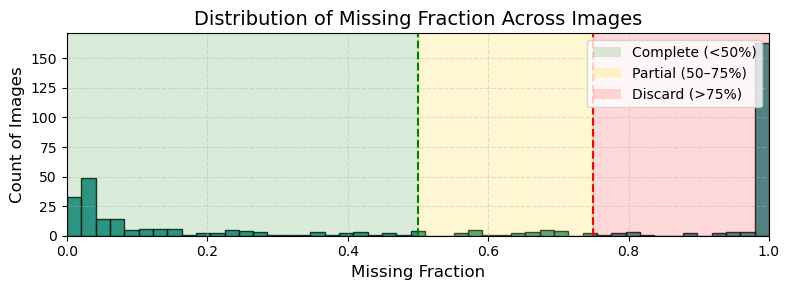

normalizer weights exist


In [11]:
#explore missing data and normalize
df_missing=count_missing_pixels_with_hist(Path("test"), missing_threshold=-1e+38, save_plot=None)
plot_missing_fraction_distribution(df_missing, save_plot="missing_fraction_hist.png")
complete = df_missing[df_missing["percent_missing"] < 60]["filename"].tolist()
partial  = df_missing[(df_missing["percent_missing"] >= 60) & (df_missing["percent_missing"] < 75)]["filename"].tolist()
blank    = df_missing[df_missing["percent_missing"] >= 75]["filename"].tolist()

normalizer = Normalizer(clip_z=5.0)          
normalizer_fiile = Path("normalizer_stats.npz")
if normalizer_fiile.is_file():
    print('normalizer weights exist')
    z = np.load("normalizer_stats.npz")
    normalizer.im_mu = float(z["im_mu"]) 
    normalizer.im_sigma = float(z["im_sigma"])
else:
    print('making normalizer')
    normalizer.fit_images(complete)
    np.savez("normalizer_stats.npz", im_mu=normalizer.im_mu, im_sigma=normalizer.im_sigma)
    z = np.load("normalizer_stats.npz")
    normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])


In [12]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,tif_dir,normalizer,file_list,train=False,use_dataset_mask=True,treat_zeros_as_missing=False,
        valid_range=None,pandora_csv=None,time_tolerance="30min",):
        self.tif_dir = tif_dir
        self.train = train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)
        order = np.argsort(np.array(self.timestamps, dtype="datetime64[ns]"))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]

        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype="float64")
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas: known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing: known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[: len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img)

        #pandora
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) & (self.pandora_df["datetime"] <= ts + self.time_tolerance)].copy()

            if not dfw.empty:
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = (
                        dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first())

                with rasterio.open(path) as src:
                    tr = src.transform
                if {"lat", "lon"}.issubset(dfw.columns):
                    xs = dfw["lon"].to_numpy()
                    ys = dfw["lat"].to_numpy()
                    rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                    cols = np.array([int(round(c)) for c, r in rc])
                    rows = np.array([int(round(r)) for c, r in rc])
                    ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                    rows, cols = rows[ok], cols[ok]
                    vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()
                    dfw_ok = dfw.loc[ok].reset_index(drop=True)

                    vals_n = vals.astype(np.float32)

                    for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                        pandora_mask[r, c] = 1.0
                        pandora_val_map[r, c] = v_n
                        station_name = (
                            dfw_ok["station"].iloc[i]
                            if "station" in dfw_ok.columns
                            else f"Station_{i}")
                        station_names.append(station_name)

        sample = {
            "p_mask": torch.from_numpy(pandora_mask),
            "p_val_mask": torch.from_numpy(pandora_val_map),
            "station_names": station_names,
            "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),
            "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),
            "target": torch.from_numpy(img_n).unsqueeze(0).float(),
            "path": path,}
        return sample

## Gap Filling

In [13]:
def visualize_batch(epoch, model, normalizer, dataloader, batch_idx=0, sample_idx=0,
                    device="cpu", save=False, train=True, shp_path=None, avg_thr=0.2,
                    pandora_df=pandora_df):

    try:
        for i, batch in enumerate(dataloader):
            if i == batch_idx:
                break
        else:
            print(f"Batch index {batch_idx} not found in dataloader")
            return
    except Exception as e:
        print(f"Error getting batch from dataloader: {e}")
        return

    batch_size = batch["masked_img"].shape[0]
    if sample_idx >= batch_size:
        print(f"Sample index {sample_idx} not available in batch of size {batch_size}")
        sample_idx = 0
        print(f"Using sample index {sample_idx} instead")

    sample = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor): sample[key] = value[sample_idx]
        elif isinstance(value, (list, tuple)): sample[key] = value[sample_idx]
        else: sample[key] = value

    p_mask = sample.get('p_mask', torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    p_val_map = sample.get('p_val_mask', torch.zeros_like(sample["known_mask"])).numpy()
    img = sample["masked_img"].unsqueeze(0).to(device)
    mask_obs = sample["known_mask"].unsqueeze(0).to(device)
    target = sample["target"].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred, out_mask = model(img, mask_obs)

    inp_np = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_obs_np = mask_obs[0,0].cpu().numpy().astype(bool)
    pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())
    pred_np = gaussian_filter(pred_np, sigma=0.5)
    mask_np = mask_obs_np
    hole_mask = ~mask_np
    pred_np_final = pred_np.copy()
    pred_np_final[hole_mask] = pred_np[hole_mask]
    path = sample["path"]
    date = path.split('/')[-1].split('.')[0]
    date = datetime.strptime(date, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width

    ts = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)
    if shp_path is not None:
        segments = load_shapefile_segments_gpd(shp_path, crs)
    else: segments = []
    pandora_rmse = None
    pandora_rho = None
    n_pandora_stations = 0
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        if len(pandora_rows) > 0:
            pandora_values = p_val_map[pandora_rows, pandora_cols]            
            pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
            valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                if len(pandora_valid) > 1:pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                n_pandora_stations = len(pandora_valid)

    finite_vals = tgt_np[np.isfinite(tgt_np)]
    if finite_vals.size: vmin, vmax = np.percentile(finite_vals, [2, 98])
    else:vmin, vmax = 0.0, 1.0
    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")
    
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                         pandora_df=pandora_df, add_legend=False, pred_np_final=None):

        legend_handles = []
        if pandora_df is None or ts is pd.NaT:
            return legend_handles

        dfw = pandora_df[ (pandora_df["datetime"] >= ts - pd.Timedelta("30min")) & (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))].copy()
        if dfw.empty:return legend_handles

        
        # Pick closest record per station
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

        stations_all = pandora_df["station"].unique()
        color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))
        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)

        if ok_ll.sum() == 0:
            return legend_handles

        dfw = dfw.loc[ok_ll].copy()
        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()
        rr_i = rr.astype(int)
        cc_i = cc.astype(int)
        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

        if rr_i.size == 0:
            return legend_handles

        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr == 0.0] = np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask):
            return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        from scipy.spatial import cKDTree
        tree = cKDTree(valid_coords)

        for x, y, lab, r, c in zip(xs, ys, labels, rr_i, cc_i):
            outline_color = color_map.get(lab, "red")
            dist, idx = tree.query([r, c])
            pandora_val = valid_values[idx]

            if np.isfinite(pandora_val): fill_color = cmap_v(norm(pandora_val))
            else:fill_color = "black"

            ax.scatter(x, y, s=100, marker='D',facecolor=fill_color,edgecolor=outline_color, linewidth=1.0,zorder=6)

            # Per-station RMSE
            rmse_str = ""
            if pred_np_final is not None and np.isfinite(pandora_val):
                pred_val = pred_np_final[r, c]
                if np.isfinite(pred_val):
                    rmse = np.sqrt((pandora_val - pred_val) ** 2)
                    rmse_str = f" (RMSE={rmse:.2E})"

            if add_legend:
                proxy = Line2D(
                    [0], [0], marker="D", color="none",
                    markerfacecolor=fill_color, markeredgecolor=outline_color, markeredgewidth=1,
                    markersize=9, label=f"{lab}\n{rmse_str}" )
                legend_handles.append(proxy)

        return legend_handles

    def add_pandora_stations(ax, add_legend=False):
        return _add_pandora_stations(
            ax=ax, tr=tr, crs=crs, H=H, W=W, ts=ts,
            p_val_map=p_val_map, vmin=vmin, vmax=vmax, cmap_v=cmap_v,
            pandora_df=pandora_df, add_legend=add_legend, pred_np_final=pred_np_final)

    fig, ax = plt.subplots(1, 3, figsize=(14, 6))
    disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~mask_obs_np))
    im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].margins(0); ax[0].autoscale(False)
    ax[0].set_title(f"Input (N/A = white)")
    ax[0].axis("off")
    ax[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
    legend_handles = add_pandora_stations(ax[0], add_legend=True)

    disp_pred = np.ma.masked_invalid(pred_np_final)
    im1 = rio_show(disp_pred, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[1].set_xlim(xmin, xmax); ax[1].set_ylim(ymin, ymax)
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].margins(0); ax[1].autoscale(False)
    ax[1].set_title("Reconstruction")
    ax[1].axis("off")
    ax[1].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
    add_pandora_stations(ax[1])        

    filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
    filled_only[~mask_obs_np] = pred_np_final[~mask_obs_np]
    ax[2].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[2].set_title("Filled Values in Holes")
    ax[2].axis("off")
    _add_shape_pixel(ax[2], segments, tr)

    if legend_handles:
        ax[0].legend(
            handles=legend_handles,
            bbox_to_anchor=(-0.85, 1),
            loc="upper left",
            frameon=True, fontsize=13, markerscale=1.3
        )
    cbar_ax = fig.add_axes([0.29, 0.05, 0.6, 0.04])  # [left, bottom, width, height] in figure coords
    cbar = fig.colorbar(im1.get_images()[0], cax=cbar_ax, orientation="horizontal")
    cbar.set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15)

    plt.suptitle(f"{date}", fontsize=18, )
    plt.tight_layout()
    plt.show()
    plt.close()

In [16]:
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")
stations_all = pandora_df["station"].unique()
station_color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

batch_size = 4
val_ds = TempoPandoraInpaintDataset(tif_dir='test', normalizer=normalizer,file_list=complete,pandora_csv=pandora_df)
val_loader = DataLoader( val_ds, batch_size=batch_size,  shuffle=False, collate_fn=custom_collate_fn )
model = OriginalPlusMinimalAttentionDeepOld(base_ch=32)  # Your original + tiny attention
model.load_state_dict(torch.load('gap_filling_model.pt', map_location=torch.device('cpu')))
val_ds = TempoPandoraInpaintDataset(tif_dir='test', normalizer=normalizer,train=False,file_list=complete,pandora_csv=pandora_df)
val_loader = DataLoader(val_ds,batch_size=4, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)
shp_dir = Path('/home/jovyan/shapefile_dir/cus')
if shp_dir.is_dir():
    print('Shapefile downloaded')
    shp_path="/home/jovyan/shapefile_dir/cus/cb_2018_us_state_500k.shp"
else: 
    shp_path= None

for i in range(len(val_loader)):
    for j in range(batch_size):
        visualize_batch(epoch=None, model=model, normalizer=normalizer, dataloader=val_loader,
                        batch_idx=i, sample_idx=j, device="cpu", save=False, shp_path=shp_path)
    

FileNotFoundError: [Errno 2] No such file or directory: 'gap_filling_model.pt'